# Space Race Analysis

Using an incredibly rich dataset from [nextspaceflight](nextspaceflight.com) that includes all the space missions since the beginning of Space Race between the USA and the Soviet Union in 1957

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import pycountry
from datetime import datetime

pd.set_option('display.max_columns', None)

### Read the Data

In [3]:
df_data = pd.read_csv('csv/mission_launches.csv')

### Data Exploration & Cleaning 

In [4]:
print(df_data.shape)
print(df_data.columns)

(4324, 9)
Index(['Unnamed: 0', 'Unnamed: 0.1', 'Organisation', 'Location', 'Date',
       'Detail', 'Rocket_Status', 'Price', 'Mission_Status'],
      dtype='object')


###    Check for Duplicates

In [5]:
print(df_data.isna().sum())
df_data_clean = df_data.fillna(0)

Unnamed: 0           0
Unnamed: 0.1         0
Organisation         0
Location             0
Date                 0
Detail               0
Rocket_Status        0
Price             3360
Mission_Status       0
dtype: int64


get time 

In [6]:
min_date = df_data.Date.min()
min_date_ = datetime.strptime(min_date, '%a %b %d, %Y %H:%M %Z')
year = min_date_.year
print(year)

1960


Convert Date to Datetime

In [7]:
df_data_clean['Date'] = pd.to_datetime(df_data_clean['Date'])
df_data_clean['Year'] = [Date.year for Date in df_data_clean.Date]

### Get Country from Location 

In [8]:
get_loc = df_data_clean['Location'].astype(str).str.split(',', expand=True)

country = []
for index in range(get_loc.shape[0]):
    if type(get_loc[3][index]) is str:
        country.append(get_loc[3][index][1:])
    elif type(get_loc[2][index]) is str:
        country.append(get_loc[2][index][1:])
    elif type(get_loc[1][index]) is str:
        country.append(get_loc[1][index][1:])
    elif type(get_loc[3][index]) is str:
        country.append(get_loc[0][index][1:])

df_data_clean['Country'] = country

Now let's know the status of the missions:
### Plotly Donut Chart: Mission Status Success and Failure


In [9]:
mission_status = df_data_clean.Mission_Status.value_counts()

fig = px.pie(labels=mission_status.index, values=mission_status.values,
             title='Mission Status',
             names=mission_status.index,
             hole=0.4
             )
fig.update_traces(textposition='inside', textfont_size=15, textinfo='percent+label')
fig.show()

<a href="img\Mission_Status.htm" target="_blank">
<img src="img\Mission Status.png">
</a>

How many missions have each Organization?

### Number of mission by Organization

In [10]:
mission_by_organization = df_data_clean.Organisation.value_counts()

bar = px.bar(mission_by_organization, x=mission_by_organization.index, y=mission_by_organization.values,
             color=mission_by_organization.values,
             color_continuous_scale='Aggrnyl',
             labels={"index": "Organization", "y": "Number", "color": "Number"}
             )
bar.update_layout(yaxis_title='Number of Missions', xaxis_title='Organization',
                  title='Number of mission by Organization')
bar.show()

<a href="img\Number of mission by Organization.htm" target="_blank">
<img src="img\Number of mission by Organization.png">
</a>

Can it be different?, How many mission by Country?

### Number of mission by Country 

In [11]:
mission_by_country = df_data_clean.Country.value_counts()

bar = px.bar(mission_by_country, x=mission_by_country.index, y=mission_by_country.values,
             color=mission_by_country.values,
             color_continuous_scale='Viridis',
             labels={"index": "Country", "y": "Number", "color": "Number"}
             )
bar.update_layout(yaxis_title='Number of Missions', xaxis_title='Country',
                  title='Number of mission by Country')
bar.show()

<a href="img\Number of mission by Country.htm" target="_blank">
<img src="img\Number of mission by Country.png">
</a>

Did the number of missions increase over the years?
### Number of mission Over Time

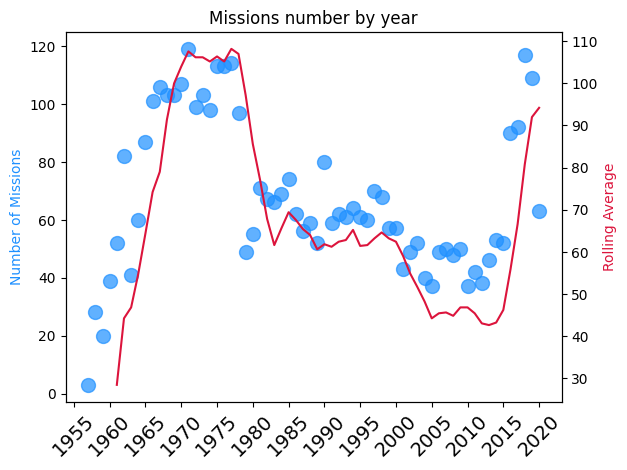

In [12]:
missions_by_year = df_data_clean.groupby(['Year'], as_index=False). agg({'Organisation': pd.Series.count})

missions_5year = df_data_clean.groupby(['Year'], as_index=False).agg({'Organisation': pd.Series.count}).\
    rolling(on='Year', window=5).mean()
missions_5year.dropna(inplace=True)


plt.figure()
plt.xticks(fontsize=14, rotation=45)
plt.title('Missions number by year')
ax1 = plt.gca()  # get the axes
ax2 = ax1.twinx()  # create another axis that shares the same x_axis
ax1.scatter(missions_by_year.Year, missions_by_year.Organisation, color='dodgerblue', alpha=0.7, s=100)
ax2.plot(missions_5year.Year, missions_5year.Organisation,  color='crimson')
ax1.set_ylabel('Number of Missions', color='dodgerblue')
ax2.set_ylabel('Rolling Average', color='crimson')
ax1.set_xticks(np.arange(1955, 2025, step=5))
plt.show()

Interesting, the observed takeoff in the number of missions during the space race. Although after the mid-80's the number of missions decreased considerably, a new spike is observed starting in 2015.

## The Countries with the Most Missions

In [13]:
Top_10_Countries = df_data_clean.groupby('Country', as_index=False).agg({'Price': pd.Series.count}).\
                       sort_values('Price', ascending=False)[0:10]


h_bar = px.bar(x=Top_10_Countries.Price, y=Top_10_Countries.Country, orientation='h',
               title='Top 10 Countries by Number of Missions', color=Top_10_Countries.Price,
               color_continuous_scale='Inferno',
               labels={"x": "Country", "y": "Number of Missions", "color": "Number of Missions"},
               ).update_yaxes(categoryorder='total ascending')
h_bar.update_layout(xaxis_title='Number of Missions', yaxis_title='Country', coloraxis_showscale=False)
h_bar.show()

<a href="img\Top 10 Countries by Number of Missions.htm" target="_blank">
<img src="img\Top 10 Countries by Number of Missions.png">
</a>

We all know who would be in the lead.

let's get a better visualization of the Countries with the Most Missions.
## Choropleth Map Number of Mission by County

In [14]:
All_Countries = df_data_clean.groupby('Country', as_index=False).agg({'Price': pd.Series.count}).\
                       sort_values('Price', ascending=False)

countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_3

[All_Countries.Country.values.__setitem__(i, 'United States')
 for i, country in enumerate(All_Countries.Country) if country == 'USA']
[All_Countries.Country.values.__setitem__(i, 'Russian Federation')
 for i, country in enumerate(All_Countries.Country) if country == 'Russia']
[All_Countries.Country.values.__setitem__(i, 'Iran, Islamic Republic of')
 for i, country in enumerate(All_Countries.Country) if country == 'Iran']
[All_Countries.Country.values.__setitem__(i, "Korea, Democratic People's Republic of")
 for i, country in enumerate(All_Countries.Country) if country == 'South Korea']
[All_Countries.Country.values.__setitem__(i, "Korea, Republic of")
 for i, country in enumerate(All_Countries.Country) if country == 'North Korea']


codes = [countries.get(country, 'Unknown code') for country in All_Countries.Country.values]
All_Countries['CODE'] = codes


map_plot = px.choropleth(All_Countries, locations='CODE',
                         title='Number of Mission by County', color='Price',
                         color_continuous_scale='Turbo',
                         hover_name='Country',
                         labels={"Price": "Number of Missions"}
                         )
map_plot.show()

<a href="img\Number of Mission by County Map.htm" target="_blank">
<img src="img\Number of Mission by County.png">
</a>


Let's follow the leaders in the Space Race.
What has the cost of these missions been over time for USA and Russia?
## Number of Mission and Cost Over Time

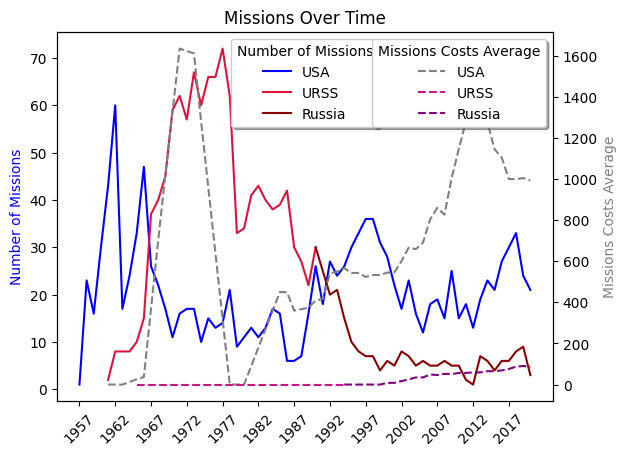

In [15]:
df_data_clean['Price'] = df_data_clean['Price'].astype(str).replace(',', '')\
    .replace('.00', '').replace('5,000.00', '5000').replace('1,160.00', '1600')
df_data_clean['Costs'] = df_data_clean['Price'].astype(float)
df_data_clean['Number'] = df_data_clean['Price']
missions_cost_by_year = df_data_clean.groupby(['Year', 'Country', 'Costs'], as_index=False).\
    agg({'Number': pd.Series.count})
pd.set_option('display.max_rows', None)

missions_USA = missions_cost_by_year[missions_cost_by_year.Country == 'USA']
missions_Russia = missions_cost_by_year[missions_cost_by_year.Country == 'Russia']

missions_USA_number = missions_USA.groupby('Year', as_index=False).sum()
missions_Russia_number = missions_Russia.groupby('Year', as_index=False).sum()

costs_5year = missions_USA_number.rolling(on='Year', window=5).mean()
costs_5year.dropna(inplace=True)
costs_5year_Russia = missions_Russia_number.rolling(on='Year', window=5).mean()
costs_5year_Russia.dropna(inplace=True)

plt.xticks(fontsize=10, rotation=45)
plt.title('Missions Over Time')
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(missions_USA_number.Year, missions_USA_number.Number, color='blue', label='USA')
ax1.plot(missions_Russia_number.Year[0:30], missions_Russia_number.Number[0:30], color='crimson', label='URSS')
ax1.plot(missions_Russia_number.Year[29:60], missions_Russia_number.Number[29:60], color='#8B0000', label='Russia')
ax2.plot(costs_5year.Year, costs_5year.Costs, '--', color='gray', label='USA')
ax2.plot(costs_5year_Russia.Year[0:30], costs_5year_Russia.Costs[0:30], '--', color='#C71585', label='URSS')
ax2.plot(costs_5year_Russia.Year[29:60], costs_5year_Russia.Costs[29:60], '--', color='purple', label='Russia')
ax1.set_ylabel('Number of Missions', color='blue')
ax2.set_ylabel('Missions Costs Average', color='gray')
ax1.legend(title='Number of Missions', loc='upper center', shadow=True, fontsize='medium')
ax2.legend(title='Missions Costs Average', loc='upper right', shadow=True, fontsize='medium')
ax1.set_xticks(np.arange(1957, 2021, step=5))
plt.show()


In this simple graph we can see how historical moments influenced the Space Race, for example, first the struggle between the USA and the USSR for the conquest of space that lasted approximately from 1956 to 1987-89 with the greatest number of missions carried out and Second after the dissolution of the USSR in 1991, the number of missions from what is now Russia has decreased since then.


Number of Mission by County Over Time 

In [16]:
missions_over_time = missions_cost_by_year.groupby(['Year', 'Country'], as_index=False).sum()


l_plot = px.line(missions_over_time, x="Year", y="Number", color='Country', markers=True,
                 title='Number of Mission by County Over Time')
l_plot.update_traces(textposition="bottom right")
l_plot.show()

<a href="img\Number of Mission by County Over Time.htm" target="_blank">
<img src="img\Number of Mission by County Over Time.png">
</a>

Who are in the top ten in the space race?
Top 10 Countries Mission Number Over Time

In [17]:
missions_country_append = []
for country in Top_10_Countries.Country:
    missions_country = missions_over_time[missions_over_time.Country == country]
    missions_country_append.append(missions_country)

missions_country_append = pd.concat(missions_country_append)

l_plot = px.line(missions_country_append, x="Year", y="Number", color='Country', markers=True,
                 title='Top 10 Countries Mission Number Over Time')
l_plot.update_traces(textposition="bottom right")
l_plot.show()

<a href="img\Top 10 Countries Mission Number Over Time.htm" target="_blank">
<img src="img\Top 10 Countries Mission Number Over Time.png">
</a>

Let's go a little further.
Where Mission Launch Take Place?

In [18]:
country_organization_status = df_data_clean.groupby(['Country', 'Organisation', 'Mission_Status'], as_index=False).\
    agg({'Price': pd.Series.count}).sort_values(['Price'], ascending=False)

sun_chart = px.sunburst(country_organization_status,
                        path=['Country', 'Organisation', 'Mission_Status'],
                        values='Price',
                        title='Where Mission Launch Take Place?',
                        labels={"Price": "Missions Number"})
sun_chart.show()

<a href="img\Where Mission Launch Take Place.htm" target="_blank">
<img src="img\Where Mission Launch Take Place.png">
</a>